# Import packages

In [1]:
print('Importing packages...')
import os
import pandas
import numpy as np
import time
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import geopandas
import scipy.stats
#from pprint import pprint
import io
from shapely.ops import unary_union
from shapely.geometry import Polygon, LineString, MultiLineString

thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
data_dir = thisdir + 'final_data/'
figdir = thisdir + 'figures/'

baltimore_shapefile_basedir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'
census_shapefile_tiger_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/'

earliest_year = 2010
latest_year = 2019

# ANALYSIS OPTIONS
sb_jobs_lower_limit = 10
pop_lower_limit = 1000
tol = 8100  # Tolerance for declaring a tract is contained in a city council district
summary = {}
equal_area_proj = 2163 #{'init': 'epsg:2163'}   # https://epsg.io/2163


# MAPPING OPTIONS
scale = 1
show_tract_labels = False
manual_colorbar = True

thecolormap = 'Greys'

show_water = True
no_data_hatch = '/'  # one of {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
water_hatch = '|'    # one of {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
not_in_city_hatch = 'x'    # one of {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}

show_plot_labels = True

g = 0

print('ok')

Importing packages...
ok


# Pick city

In [2]:
s = time.time()
city = 'St. Louis'

# Default values will be changed for specific citites if needed
top_of_color_scale = 300000
color_scale_tick_interval = 50000
color_scale_unit = 'thousand'


if (city == 'Cleveland'):
    projection = {'init': 'EPSG:3734'}
    thestate = 39
    top_of_color_scale = 3000000
    color_scale_tick_interval = 500000
    color_scale_unit = 'million'
elif (city == 'Baltimore'):
    projection = {'init': 'EPSG:6487'}
    thestate = 24
    top_of_color_scale = 450000
    #color_scale_tick_interval = 50000    
elif (city == 'Washington D.C.'):
    #projection = {'init': 'EPSG:6487'}
    projection = {'init': 'EPSG:3857'}
    thestate = 11
elif (city == 'Detroit'):
    projection = {'init': 'EPSG:2253'}
    thestate = 26
    top_of_color_scale = 900000
    color_scale_tick_interval = 100000
elif (city == 'Philadelphia'):
    thestate = 42
    projection = {'init': 'EPSG:2272'}
    top_of_color_scale = 400000
    color_scale_tick_interval = 50000
elif (city == 'Pittsburgh'):
    thestate = 42
    projection = {'init': 'EPSG:2272'}
    top_of_color_scale = 350000
    color_scale_itck_interval = 50000
elif (city == 'St. Louis'):
    thestate = 29
    projection = {'init': 'EPSG:6512'}
    top_of_color_scale = 350000
    color_scale_tick_interval = 50000
    
elif (city == 'Newark'):
    thestate = 34
    projection = {'init': 'EPSG:3424'}
    top_of_color_scale = 350000
    color_scale_itck_interval = 50000

else:
    print('Pick a city. Possible values:\n\tBaltimore, Washington D.C., Detroit, Newark, St. Louis, Richmond, San Francisco, Cleveland, Philadelphia, Pittsburgh\n')
e = time.time()
g = g + (e-s)
print('Selected {0:}!'.format(city)) 

Selected St. Louis!


# Get raw data

In [3]:
s = time.time()
print('loading numerical data...')
city_name_parsed = city.replace(".","").replace(" ","_").lower()
raw_data_df = pandas.read_csv(data_dir+'{0:}_{1:.0f}_{2:.0f}_no_geo.csv'.format(city_name_parsed, earliest_year, latest_year))
raw_data_df = raw_data_df.set_index(['GEOID', 'year'])

print('loading shapefile data...')
shapefiles_gdf = geopandas.read_file(data_dir+'{0:}_{1:.0f}_{2:.0f}_shapefiles.shp'.format(city_name_parsed, earliest_year, latest_year))
shapefiles_gdf = shapefiles_gdf.set_index(['GEOID', 'year'])

if (city == 'Baltimore'):
    baltimore_shapefiles_gdf = geopandas.read_file(baltimore_shapefile_basedir+'tl_2017_24_tract/tl_2017_24_tract.shp')
    baltimore_shapefiles_gdf = baltimore_shapefiles_gdf[baltimore_shapefiles_gdf['COUNTYFP'] == '510']

print('combining...')
raw_data_gdf = geopandas.GeoDataFrame(data=raw_data_df.join(shapefiles_gdf), columns=raw_data_df.join(shapefiles_gdf).columns, crs=shapefiles_gdf.crs, geometry='geometry')
#data_gdf.plot(column='amtLoans_adj')

# # if (city == 'Washington D.C.'):
# #     print('removing duplicates from D.C....')
# #     raw_data_gdf = raw_data_gdf.reset_index().drop_duplicates().set_index(['county','census_tract','year'])

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} rows by {1:,.0f} columns in {2:,.1f} seconds!'.format(raw_data_gdf.shape[0], raw_data_gdf.shape[1], e-s))
#[x for x in raw_data_gdf.columns.tolist() if 'rent' in x]


loading numerical data...
loading shapefile data...
combining...
Read 1,060 rows by 375 columns in 0.6 seconds!


# Process to make a dataframe we can map

In [4]:
s = time.time()

print('creating summary data frame...')
data_df = pandas.DataFrame(data=None, index=raw_data_gdf.xs(latest_year, level='year').index)

tract_label_columns = ['state', 'county', 'census_tract']
data_df = pandas.concat((data_df, raw_data_gdf[tract_label_columns].xs(latest_year, level='year')), axis=1) # census tract numbers

print('summing loan columns...')
sum_columns = []
sum_columns += ['nLoans1', 'amtLoans1_adj', 'nLoans100k', 'amtLoans100k_adj', 'nLoans250k', 'amtLoans250k_adj']
sum_columns += ['nLoansToSmallest', 'amtLoansToSmallest_adj', 'nLoans', 'amtLoans_adj']
sum_columns += ['nWorkingLoans', 'amtWorkingLoans_adj']
sum_columns += ['nLoans1_per_totaljob', 'amtLoans1_per_totaljob_adj']
sum_columns += ['nLoans100k_per_totaljob', 'amtLoans100k_per_totaljob_adj']
sum_columns += ['nLoans250k_per_totaljob', 'amtLoans250k_per_totaljob_adj']
sum_columns += ['nLoansToSmallest_per_totaljob', 'amtLoansToSmallest_per_totaljob_adj']
sum_columns += ['nLoans_per_totaljob', 'amtLoans_per_totaljob_adj']
sum_columns += ['nWorkingLoans_per_totaljob', 'amtWorkingLoans_per_totaljob_adj']
sum_columns += ['nLoans1_per_sbjob', 'amtLoans1_per_sbjob_adj']
sum_columns += ['nLoans100k_per_sbjob', 'amtLoans100k_per_sbjob_adj']
sum_columns += ['nLoans250k_per_sbjob', 'amtLoans250k_per_sbjob_adj']
sum_columns += ['nLoansToSmallest_per_sbjob', 'amtLoansToSmallest_per_sbjob_adj']
sum_columns += ['nLoans_per_sbjob', 'amtLoans_per_sbjob_adj']
sum_columns += ['nWorkingLoans_per_sbjob', 'amtWorkingLoans_per_sbjob_adj']

for thiscol in sum_columns:
    data_df = pandas.concat((data_df, raw_data_gdf.reset_index().groupby(['GEOID'])[thiscol].sum()), axis=1)

print('adding CRA info columns...')
cra_info_columns = ['income_group_code', 'income_group', 'cra_level']
data_df = pandas.concat((data_df, raw_data_gdf[cra_info_columns].xs(latest_year, level='year')), axis=1)

for thiscol in cra_info_columns:
    data_df = data_df.rename(columns={thiscol: '{0:}_{1:.0f}'.format(thiscol, latest_year)})

print('adding jobs columns...')

jobs_columns = []
jobs_columns += ['total_jobs', 'sb_jobs', 'C000', 'CA01', 'CA02', 'CA03']
jobs_columns += ['CE01', 'CE02', 'CE03', 'CNS01', 'CNS02', 'CNS03', 'CNS04', 'CNS05']
jobs_columns += ['CNS06', 'CNS07', 'CNS08', 'CNS09', 'CNS10', 'CNS11', 'CNS12']
jobs_columns += ['CNS13', 'CNS14', 'CNS15', 'CNS16', 'CNS17', 'CNS18', 'CNS19', 'CNS20']
jobs_columns += ['CR01', 'CR02', 'CR03', 'CR04', 'CR05', 'CR07', 'CT01', 'CT02']
jobs_columns += ['CD01', 'CD02', 'CD03', 'CD04', 'CS01', 'CS02']
jobs_columns += ['CFA01', 'CFA02', 'CFA03', 'CFA04', 'CFA05']
jobs_columns += ['CFS01', 'CFS02', 'CFS03', 'CFS04', 'CFS05']

data_df = pandas.concat((data_df, raw_data_gdf[jobs_columns].xs(latest_year-1, level='year')), axis=1)


for thiscol in jobs_columns:
    if (latest_year == 2019):
        data_df = data_df.rename(columns={thiscol: '{0:}_{1:.0f}'.format(thiscol, latest_year-1)})
    else:
        data_df = data_df.rename(columns={thiscol: '{0:}_{1:.0f}'.format(thiscol, latest_year)})

print('copying latest year\'s demographics values...')



# # census count errors
# new_columns += ['pop_total_err','pop_by_race_total_err','pop_white_err','pop_black_err']
# new_columns += ['total_households_err','white_householders_err','black_householders_err','female_householders_err']
# new_columns += ['total_housing_units_err','occupied_housing_units_err','vacant_housing_units_err']
# new_columns += ['educated_serr','unemployed_16plus_err','poverty_past_12_months_err','mfi_err'] # high school graduates (ages 25+), unemployed, in poverty, MFI, travel time to work
# new_columns += ['owner_occ_housing_units_err','median_home_value_err', 'median_year_built_err'] # home
# new_columns += ['pop_25plus_err','labor_force_16plus_err','poverty_status_known_err']

# # census percentages and their errors
# new_columns += ['pct_white','pct_black','pct_white_householders','pct_black_householders','pct_female_householders']
# new_columns += ['peducated','pct_unemployed','pct_poverty','pct_vacant', 'pct_household_familiy', 'pct_rent']
# new_columns += ['pct_white_serr','pct_black_serr','pct_white_householders_serr','pct_black_householders_serr','pct_female_householders_serr']
# new_columns += ['peducated_serr','pct_unemployed_serr','pct_poverty_serr','pct_vacant_serr', 'pct_household_familiy_serr', 'pct_rent_serr']
# new_columns += ['household_type_family_err', 'household_type_nonfamily_err', 'household_type_total_err', 'tenure_rent_err', 'tenure_total_err']



demographics_columns = []
demographics_columns += ['pop_total', 'pop_by_race_total', 'pop_white', 'pop_black']
demographics_columns += ['total_households', 'white_householders', 'black_householders', 'female_householders']
demographics_columns += ['total_housing_units', 'occupied_housing_units', 'vacant_housing_units']
demographics_columns += ['educated', 'unemployed_16plus', 'poverty_past_12_months', 'mfi_adj']
demographics_columns += ['owner_occ_housing_units', 'median_home_value', 'year_built', 'median_year_built']
demographics_columns += ['pop_25plus', 'labor_force_16plus', 'poverty_status_known']
demographics_columns += ['household_type_family', 'household_type_nonfamily', 'household_type_total', 'tenure_rent', 'tenure_total']

demographics_columns += ['pop_total_err', 'pop_by_race_total_err', 'pop_white_err', 'pop_black_err']
demographics_columns += ['total_households_err', 'white_householders_err', 'black_householders_err', 'female_householders_err']
demographics_columns += ['total_housing_units_err', 'occupied_housing_units_err', 'vacant_housing_units_err']
demographics_columns += ['educated_serr', 'unemployed_16plus_err', 'poverty_past_12_months_err', 'mfi_err']
demographics_columns += ['owner_occ_housing_units_err', 'median_home_value_err', 'pop_25plus_err', 'labor_force_16plus_err', 'poverty_status_known_err']
demographics_columns += ['household_type_family_err', 'household_type_nonfamily_err', 'household_type_total_err', 'tenure_rent_err', 'tenure_total_err']

demographics_columns += ['pct_white', 'pct_black']
demographics_columns += ['pct_white_householders', 'pct_black_householders', 'pct_female_householders']
demographics_columns += ['peducated', 'pct_unemployed', 'pct_poverty', 'pct_vacant']
demographics_columns += ['pct_white_serr', 'pct_black_serr']
demographics_columns += ['pct_white_householders_serr', 'pct_black_householders_serr', 'pct_female_householders_serr']
demographics_columns += ['peducated_serr', 'pct_unemployed_serr', 'pct_poverty_serr', 'pct_vacant_serr']
demographics_columns += ['pct_household_family', 'pct_rent', 'pct_household_family_serr', 'pct_rent_serr']
data_df = pandas.concat((data_df, raw_data_gdf[demographics_columns].xs(latest_year, level='year')), axis=1)

for thiscol in demographics_columns:
    data_df = data_df.rename(columns = {thiscol: thiscol+'_{0:.0f}'.format(latest_year)})

geo_info_columns = []
if (city == 'Baltimore'):
    geo_info_columns += ['split_county_indicator', 'population_classification', 'CSA2010']
else:
    geo_info_columns += ['split_county_indicator', 'population_classification']
geo_info_columns += ['NAMELSAD', 'MTFCC', 'FUNCSTAT']
geo_info_columns += ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']

data_df = pandas.concat((data_df, raw_data_gdf[geo_info_columns].xs(latest_year, level='year')), axis=1)

for thiscol in geo_info_columns:
    data_df = data_df.rename(columns = {thiscol: thiscol+'_{0:.0f}'.format(latest_year)})

print('adding {0:.0f} geometry...'.format(latest_year))

data_df = data_df.join(raw_data_gdf.xs(latest_year, level='year')['geometry'])


#data_df = data_df.join()
all_tracts_gdf = geopandas.GeoDataFrame(data_df, crs=raw_data_gdf.crs, geometry='geometry')

print('selecting only tracts with {0:,.0f} or more jobs and {1:,.0f} or more people...'.format(sb_jobs_lower_limit,pop_lower_limit))

tracts_included_gdf = all_tracts_gdf[
    (all_tracts_gdf['total_jobs_2018'] > sb_jobs_lower_limit)
    & (all_tracts_gdf['pop_total_2019'] > pop_lower_limit)
]

# if (city == 'Baltimore'):
#     baltimore_shapefiles_gdf = baltimore_shapefiles_gdf.to_crs(tracts_included_gdf.crs)

e = time.time()
g = g + (e-s)

print('\nDone in {0:,.1f} seconds!'.format(e-s))

#all_tracts_gdf[['sb_jobs_2018', 'pop_total_2019']]


creating summary data frame...
summing loan columns...
adding CRA info columns...
adding jobs columns...
copying latest year's demographics values...
adding 2019 geometry...
selecting only tracts with 10 or more jobs and 1,000 or more people...

Done in 0.7 seconds!


## Read water area shapefiles

In [5]:
s = time.time()

if (show_water):
    print('reading water files...')
    water_dir = census_shapefile_tiger_basedir+"{0:.0f}/AREAWATER/".format(latest_year)
    water_files = [water_dir+x for x in os.listdir(water_dir) if ('tl_{0:.0f}_{1:02d}'.format(latest_year,thestate) in x) and (x[-3:] == 'shp')]
    water_gdf = geopandas.GeoDataFrame()
    for i in range(0, len(water_files)):
        if ((np.mod(i,10) == 0) | (i == len(water_files)-1)):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_files)))
        water_gdf = pandas.concat((water_gdf, geopandas.read_file(water_files[i])))
    water_gdf = water_gdf.to_crs(all_tracts_gdf.crs)
    print('\tfinding water within city...')
    city_water_gdf = geopandas.overlay(water_gdf, geopandas.GeoDataFrame(data=[[unary_union(all_tracts_gdf.geometry.tolist())]], columns=['geometry'], crs=all_tracts_gdf.crs, geometry='geometry'), how='intersection')    

    if (city == 'Baltimore'):
        #city_water_gdf.plot(ax=ax, color='orange')
        #print(city_water_gdf.loc[city_water_gdf.to_crs(equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).index.tolist()])
        baltimore_water_gdf = city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'hbr' in str(x).lower())]#.plot(ax=ax, color='cyan')                
        baltimore_water_gdf = pandas.concat((baltimore_water_gdf, city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'patapsco' in str(x).lower())]), axis=0, sort=False)#.plot(ax=ax, color='cyan')
        baltimore_water_gdf = pandas.concat((baltimore_water_gdf, city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'curtis' in str(x).lower())]), axis=0, sort=False)#.plot(ax=ax, color='cyan')
        baltimore_water_gdf = pandas.concat((baltimore_water_gdf, city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'colgate' in str(x).lower())]), axis=0, sort=False)#.plot(ax=ax, color='cyan')
        baltimore_water_gdf = pandas.concat((baltimore_water_gdf, city_water_gdf[city_water_gdf['HYDROID'] == '110190589339']), axis=0, sort=False)#.plot(ax=ax, color='cyan')   # Inner Harbor
        baltimore_water_gdf = pandas.concat((baltimore_water_gdf, city_water_gdf[city_water_gdf['HYDROID'].isin(['110190589337','110190589300'])]), axis=0, sort=False)#.plot(ax=ax, color='cyan')   # Two other spots in the harbor
        city_water_gdf = baltimore_water_gdf
    elif (city == 'Washington D.C.'):
        city_water_gdf = city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: ('potomac' in str(x).lower()) | ('anacostia' in str(x).lower()) | ('washington chnnl' in str(x).lower()))]#.plot(ax=ax, color='cyan')
    elif (city == 'Cleveland'):
        city_water_gdf = city_water_gdf.loc[city_water_gdf.to_crs(epsg=equal_area_proj).geometry.area.sort_values(ascending=False).head(3).index.tolist()]
    elif (city == 'Detroit'):
        detroit_water_gdf = city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'riv' in str(x).lower())]
        detroit_water_gdf = pandas.concat((detroit_water_gdf, city_water_gdf[city_water_gdf['HYDROID'].isin(['1107295328725','1107295323725'])]), axis=0, sort=False)
        city_water_gdf = detroit_water_gdf
    elif (city == 'Philadelphia'):
        philadelphia_water_gdf = city_water_gdf[
            city_water_gdf['FULLNAME'].apply(lambda x: (str(x).lower()[-3:] == 'riv') | (str(x).lower()[-3:] == 'crk')) 
        ]
        philadelphia_water_gdf = pandas.concat((philadelphia_water_gdf, city_water_gdf[city_water_gdf['HYDROID'].isin(['110687646436','110687646470','1103689733768','1103017430436',])]), axis=0, sort=False)
        city_water_gdf = philadelphia_water_gdf
    elif (city == 'Pittsburgh'):
        city_water_gdf = city_water_gdf[
            city_water_gdf['FULLNAME'].apply(lambda x: str(x).lower()[-3:] == 'riv') 
        ]
    elif (city == 'St. Louis'):
        city_water_gdf = city_water_gdf[(city_water_gdf['FULLNAME'] == 'Mississippi Riv') | (city_water_gdf['FULLNAME'] == 'River Des Peres')]
    else:
        pass
else:
    print('not showing water in this script; to show water, set show_water = True')

print('backing up all geodataframes...')
all_tracts_gdf_bk = all_tracts_gdf
tracts_included_gdf_bk = tracts_included_gdf
if (city == 'Baltimore'):
    baltimore_shapefiles_gdf_bk = baltimore_shapefiles_gdf
city_water_gdf_bk = city_water_gdf

e = time.time()
g = g + (e-s)

print('Done in {0:,.1f} seconds!'.format(e-s))

# # for ix, thisrow in city_water_gdf.iterrows():
# #     ax.annotate(thisrow['HYDROID'], 
# #                  xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                  xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y),
# #                 backgroundcolor='white'
# #                 )


reading water files...
	reading water file 1 of 115...
	reading water file 11 of 115...
	reading water file 21 of 115...
	reading water file 31 of 115...
	reading water file 41 of 115...
	reading water file 51 of 115...
	reading water file 61 of 115...
	reading water file 71 of 115...
	reading water file 81 of 115...
	reading water file 91 of 115...
	reading water file 101 of 115...
	reading water file 111 of 115...
	reading water file 115 of 115...
	finding water within city...
backing up all geodataframes...
Done in 123.8 seconds!


getting from backup...


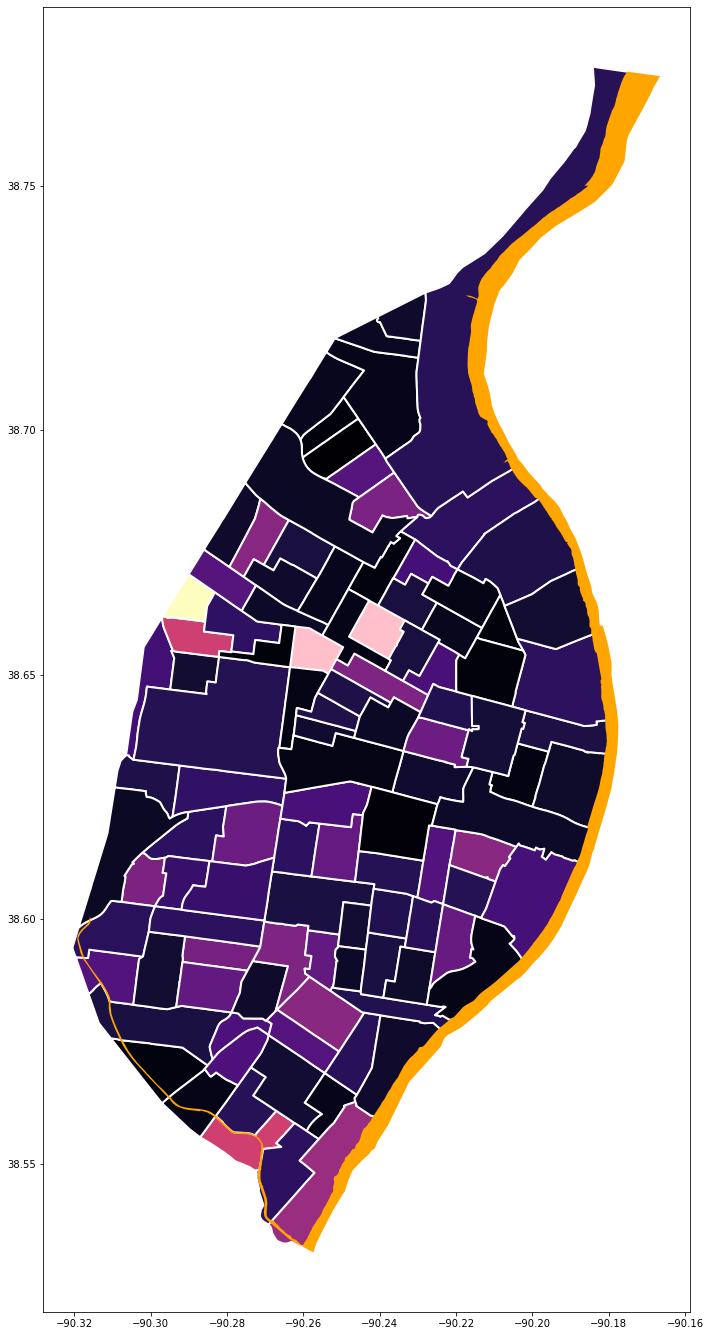

,ANSICODE,HYDROID,FULLNAME,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,None,1102212977721,Mississippi Riv,H3010,0,10231785,+38.5333170,-90.2601660,"POLYGON ((-90.26017 38.53332, -90.25989 38.533..."
10,None,110451975812,River Des Peres,H3010,0,434215,+38.5457850,-90.2713852,"POLYGON ((-90.31919 38.59619, -90.31916 38.596..."


In [6]:

thecolormap = 'magma'
# xmin = 2660000
# xmax = 2670000
# ymin = 200000
# ymax = 220000

print('getting from backup...')
all_tracts_gdf = all_tracts_gdf_bk
tracts_included_gdf = tracts_included_gdf_bk
city_water_gdf = city_water_gdf_bk

fig, ax = plt.subplots(1,1,figsize=(24*scale,24*scale))
all_tracts_gdf.plot(ax=ax, color='pink', linewidth=2*scale)
tracts_included_gdf.plot(ax=ax, column='amtWorkingLoans_per_sbjob_adj', cmap=thecolormap, edgecolor='white', linewidth=2*scale)

city_water_gdf.plot(ax=ax, color='orange')
#city_water_gdf[(city_water_gdf['FULLNAME'] == 'Mississippi Riv') | (city_water_gdf['FULLNAME'] == 'River Des Peres')].plot(ax=ax, color='cyan')


plt.show()
city_water_gdf.loc[
    city_water_gdf.to_crs(epsg=equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).head(2).index.tolist()
]




In [7]:

# city_water_gdf.plot(ax=ax, color='cyan')

# # city_water_gdf[
# #             city_water_gdf['FULLNAME'].apply(lambda x: str(x).lower()[-3:] == 'riv') 
# #         ].plot(ax=ax, color='cyan')

# # city_water_gdf.loc[
# #     city_water_gdf.to_crs(equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).head(8).index.tolist()
# # ].plot(ax=ax, color='cyan')


# #city_water_gdf.plot(ax=ax, color='cyan')


# # u = []
# # for ix, thisrow in city_water_gdf.iterrows():
# # #     print(thisrow.geometry.centroid.coords[0][0])
# # #     print(thisrow.geometry.centroid.coords[0][1])
# # #     print('\n')
# #     if (((thisrow.geometry.centroid.coords[0][0] >= xmin) & (thisrow.geometry.centroid.coords[0][0] <= xmax)) & ((thisrow.geometry.centroid.coords[0][1] >= ymin) & (thisrow.geometry.centroid.coords[0][1] <= ymax))):
# #         ax.annotate(thisrow['HYDROID'], 
# #                      xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                      xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y),
# #                     backgroundcolor='white'
# #                     )
# #         u.append(thisrow['HYDROID'])
# # plt.xlim([xmin,xmax])
# # plt.ylim([ymin,ymax])
# plt.show()




# city_water_gdf.loc[
#     city_water_gdf.to_crs(equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).index.tolist()
# ]

# #city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: (str(x).lower()[-3:] == 'riv') | (str(x).lower()[-3:] == 'crk'))]
# #u
print('ok')

ok


## Find city enclaves and exclaves

In [8]:
union_gdf = geopandas.GeoDataFrame(data=[[unary_union(all_tracts_gdf.geometry.tolist())]], columns=['geometry'], crs=all_tracts_gdf.crs, geometry='geometry')

if (len(union_gdf.geometry.boundary) == 1):
    print('no enclaves or exclaves!')
print('ok')

no enclaves or exclaves!
ok


In [9]:

# union_gdf = geopandas.GeoDataFrame(unary_union(all_tracts_gdf.geometry.tolist()), columns=['geometry'], crs=all_tracts_gdf.crs, geometry='geometry')

# boundary_raw_gdf = geopandas.GeoDataFrame(data=union_gdf.geometry.boundary, columns=['geometry'], crs=union_gdf.crs, geometry='geometry')

# boundary_list = []
# #boundary_gdf = geopandas.GeoDataFrae(data=None, columns=['geometry'], crs=boundary_raw_gdf.crs, geometry='geometry')


# for ix, thisrow in boundary_raw_gdf.iterrows():
#     if (thisrow.geometry.type == 'MultiLineString'):
#         boundary_list = boundary_list + [x for x in thisrow.geometry.simplify(tolerance = 100)]
#     else:
#         boundary_list.append(thisrow.geometry)

# city_boundary_parts_gdf = geopandas.GeoDataFrame(data=[Polygon(x) for x in boundary_list], columns=['geometry'], crs=union_gdf.crs, geometry='geometry')

# city_boundary_parts_gdf = city_boundary_parts_gdf.assign(area = city_boundary_parts_gdf.geometry.apply(lambda x: x.area))

# city_boundary_parts_gdf = city_boundary_parts_gdf.sort_values(by='area', ascending=False).reset_index(drop=True)

# city_boundary_parts_gdf = city_boundary_parts_gdf.assign(thetype = np.nan)

# city_boundary_parts_gdf.loc[0, 'thetype'] = 'main'
# main_city_geo = city_boundary_parts_gdf[city_boundary_parts_gdf['thetype'] == 'main'].geometry.values[0]


# city_boundary_parts_gdf.loc[
#     (
#         (city_boundary_parts_gdf['thetype'].isnull()) 
#         & (city_boundary_parts_gdf.geometry.apply(lambda x: x.within(main_city_geo)))
#     ), 'thetype'] = 'enclave'

# city_boundary_parts_gdf.loc[
#     (
#         (city_boundary_parts_gdf['thetype'].isnull()) 
#         & (~city_boundary_parts_gdf.geometry.apply(lambda x: x.within(main_city_geo)))
#     ), 'thetype'] = 'exclave'

# # #city_boundary_parts_gdf.loc[city_boundary_parts_gdf[city_boundary_parts_gdf['thetype'] != 'main'].geometry.apply(lambda x: not(x.within(main_city_geo))), 'thetype'] = 'exclave'

# # fig, ax = plt.subplots(1,1)

# # union_gdf.plot(ax=ax, color='pink')
# # #all_tracts_gdf.plot(ax=ax, color='none', edgecolor='black')
# # #city_boundary_parts_gdf[city_boundary_parts_gdf['thetype'] == 'enclave'].plot(ax=ax, color='cyan', alpha=0.5)

# # plt.show()
# print(city_boundary_parts_gdf)#[city_boundary_parts_gdf['thetype'] == 'enclave']



In [10]:


# fig, ax = plt.subplots(1,1,figsize=(24*scale,24*scale))
# baltimore_shapefiles_gdf.plot(ax=ax, color='pink')
# tracts_included_gdf.plot(ax=ax, column='amtWorkingLoans_per_sbjob_adj', cmap=thecolormap, edgecolor='white', linewidth=2*scale)


# # #city_water_gdf.plot(ax=ax, color='orange')
# # print(city_water_gdf.loc[city_water_gdf.to_crs(equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).index.tolist()])
# # city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'hbr' in str(x).lower())].plot(ax=ax, color='cyan')                
# # city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'patapsco' in str(x).lower())].plot(ax=ax, color='cyan')
# # city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'curtis' in str(x).lower())].plot(ax=ax, color='cyan')
# # city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'colgate' in str(x).lower())].plot(ax=ax, color='cyan')
# # city_water_gdf[city_water_gdf['HYDROID'] == '110190589339'].plot(ax=ax, color='cyan')   # Inner Harbor
# # city_water_gdf[city_water_gdf['HYDROID'].isin(['110190589337','110190589300'])].plot(ax=ax, color='cyan')   # Two other spots in the harbor
# # # for ix, thisrow in city_water_gdf.iterrows():
# # #     ax.annotate(thisrow['HYDROID'], 
# # #                  xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# # #                  xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y),
# # #                 backgroundcolor='white'
# # #                 )



# # city_water_gdf.loc[
# #     city_water_gdf.to_crs(equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).head(5).index.tolist()
# # ].plot(ax=ax, color='cyan')

# #city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'hbr' in str(x).lower())].plot(ax=ax, color='cyan')
# city_water_gdf.plot(ax=ax, color='cyan')

# # plt.xlim([430000,442000])
# # plt.ylim([170000,180000])
# plt.show()



print('ok')

ok


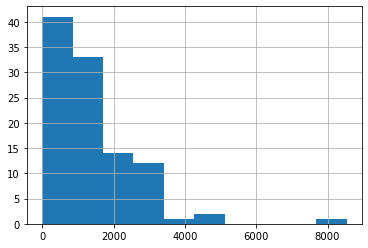

In [11]:
s = time.time()

tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'].hist()
e = time.time()
g = g + (e-s)
plt.show()

making basic map...
adding legend to label hatched area(s)...
setting options...
adding water layer...
adding colorbar...


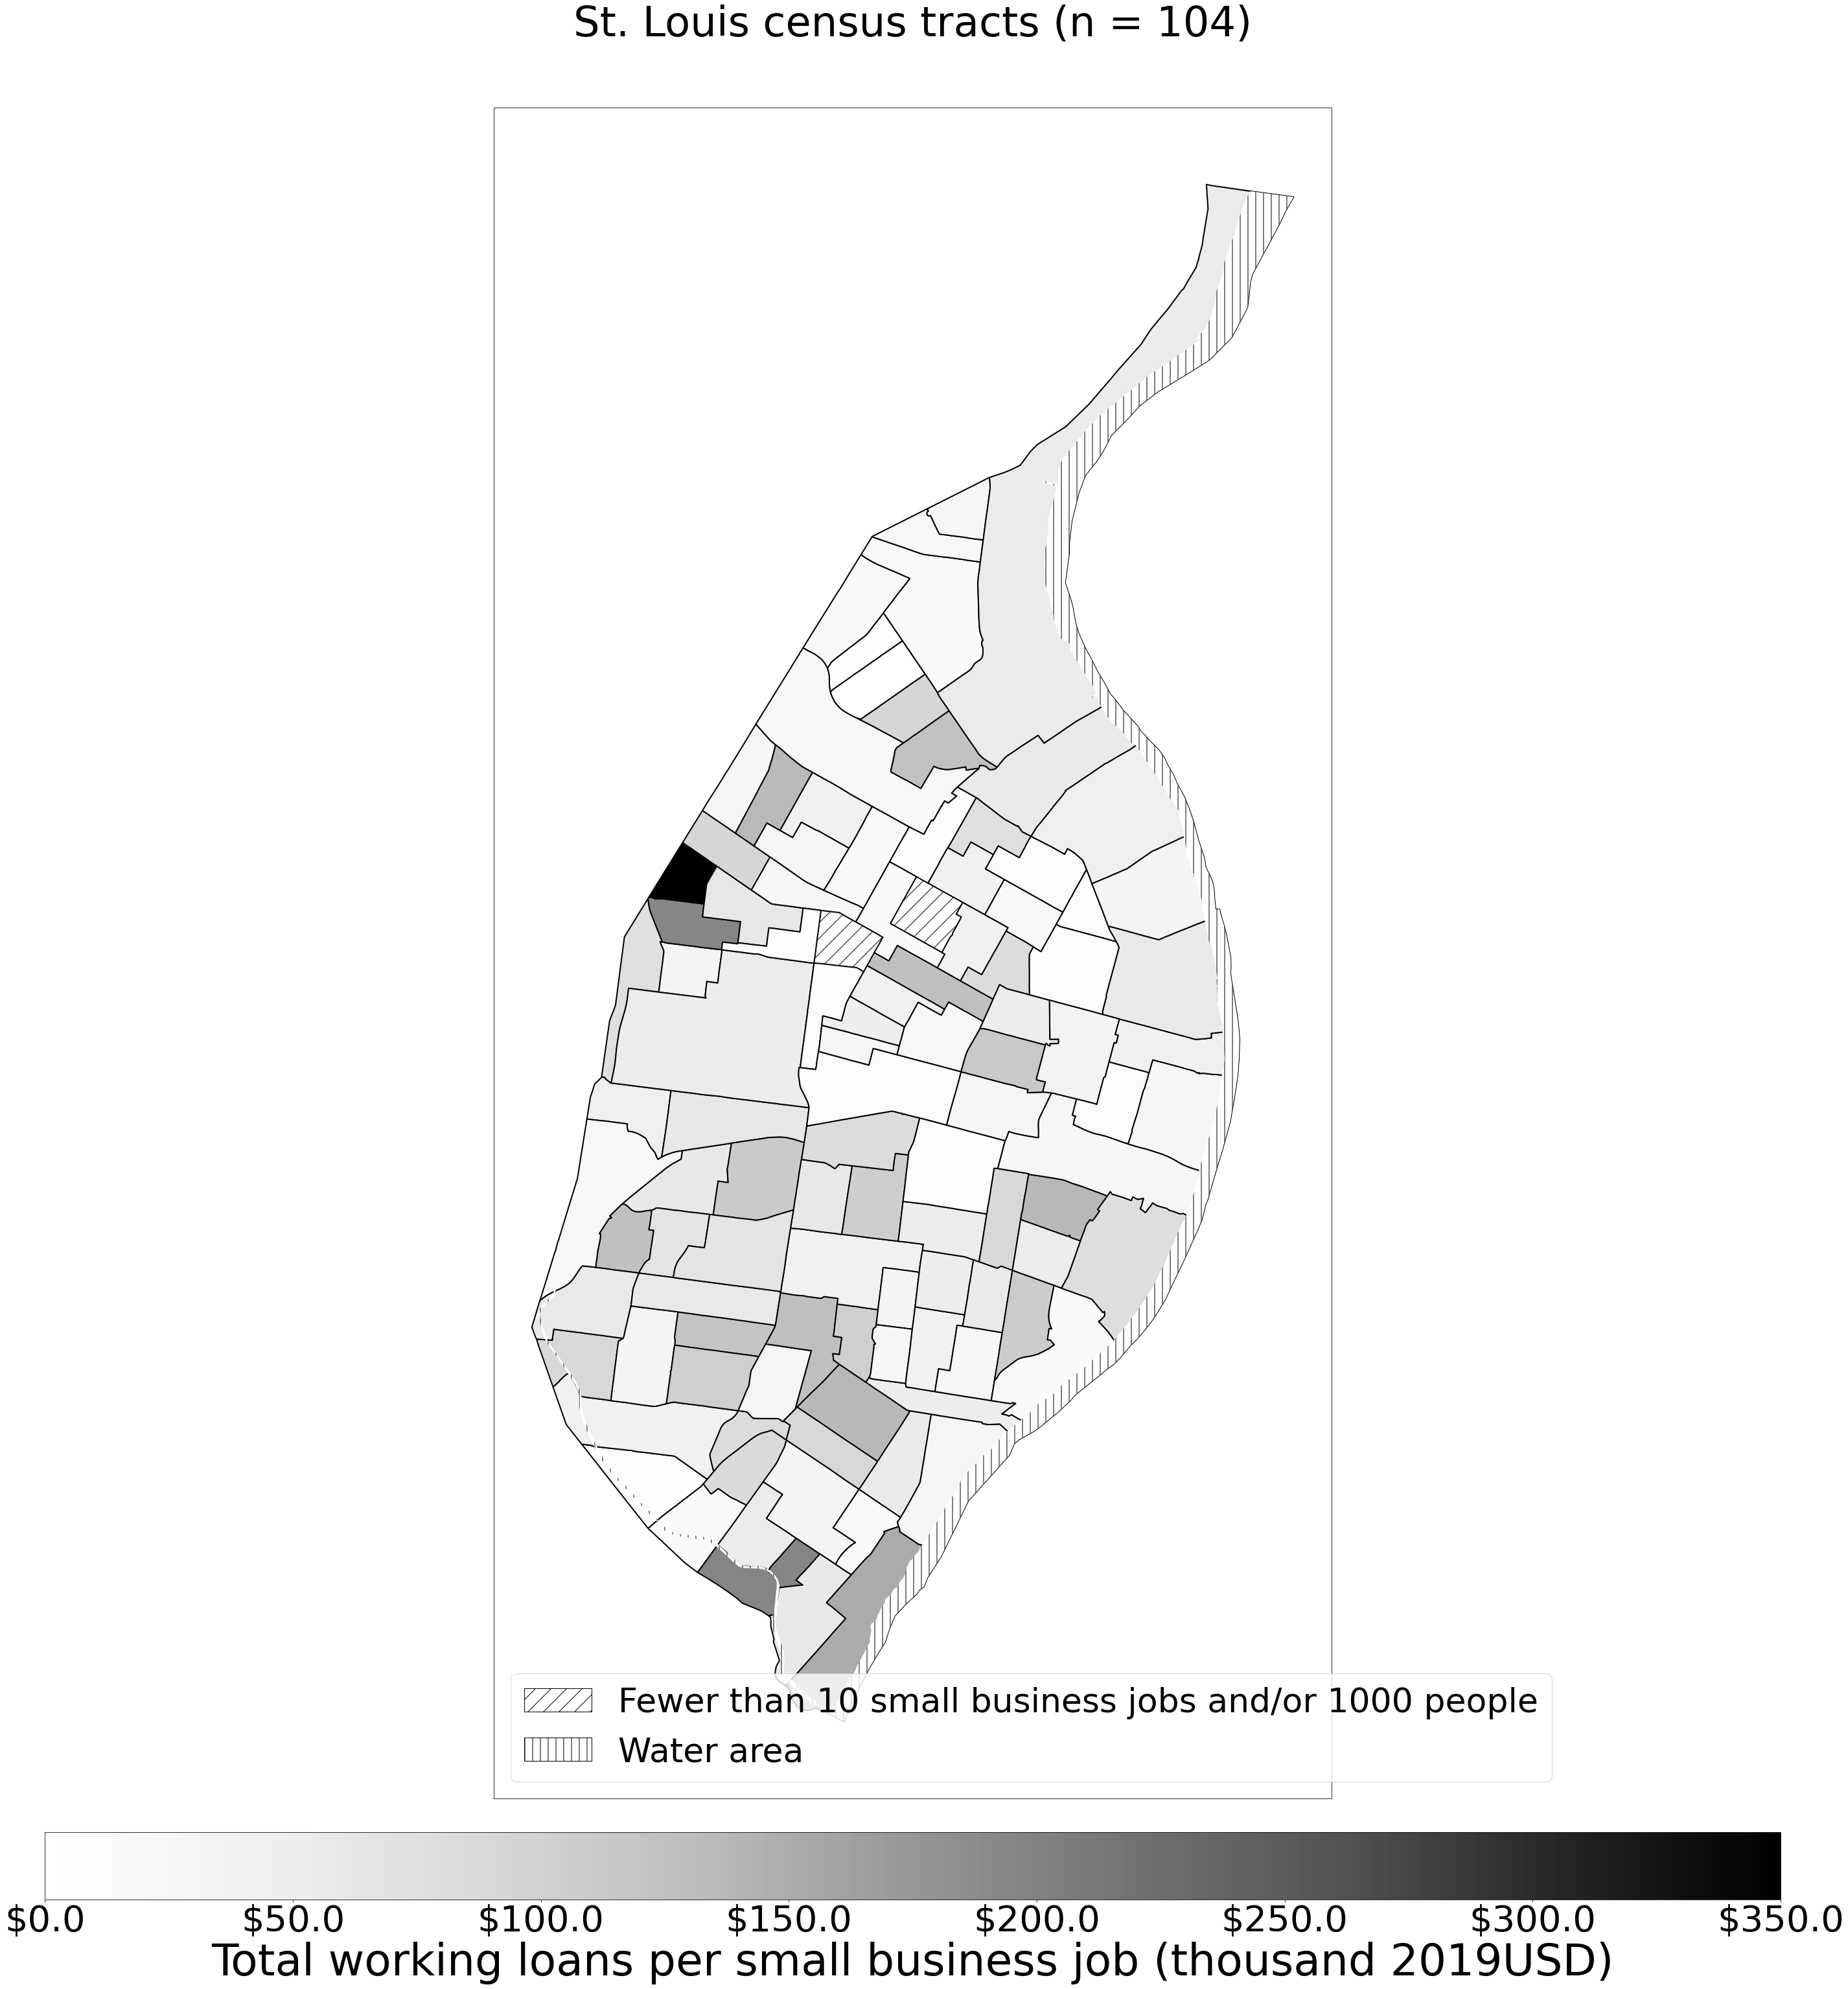

Created map in 24 seconds!
8533.422204413882


9000.0

In [12]:
s = time.time()
thecolormap = 'Greys'
print('making basic map...')

fig1, ax = plt.subplots(1,1, figsize=(48*scale, 48*scale))

# if (city == 'Pittsburgh'):
#     city_boundary_parts_gdf[city_boundary_parts_gdf['thetype'] == 'enclave'].plot(ax=ax, color='white', hatch=not_in_city_hatch, edgecolor='black')

# if (city == 'Baltimore'):
#     baltimore_shapefiles_gdf.plot(ax=ax, color='white', hatch=no_data_hatch, edgecolor='black')
# else:

print('adding legend to label hatched area(s)...')

no_data_legendizer = mpatches.Patch(facecolor='white', edgecolor='black', hatch=no_data_hatch, label='Fewer than {0:.0f} small business jobs and/or {1:.0f} people'.format(sb_jobs_lower_limit, pop_lower_limit))
legendizer_list = [no_data_legendizer]

if (show_water):
    water_legendizer = mpatches.Patch(facecolor='white', edgecolor='black', hatch=water_hatch, label='Water area')
    legendizer_list.append(water_legendizer)
# if (city == 'Pittsburgh'):
#     not_in_city_legendizer = mpatches.Patch(facecolor='white', edgecolor='black', hatch=not_in_city_hatch, label='Not part of city')
#     legendizer_list.append(not_in_city_legendizer)
    
#if (len(legendizer_list) == 3):
if ((city == 'Detroit') | (city == 'Cleveland') | (city == 'Philadelphia')):
    plt.legend(handles=legendizer_list, fontsize=52*scale, loc='lower right')
else:
    plt.legend(handles=legendizer_list, fontsize=52*scale, loc='lower left')
# else:
#     plt.legend(handles=legendizer_list, fontsize=52*scale, loc='upper left')

all_tracts_gdf.plot(ax=ax, color='white', hatch=no_data_hatch, edgecolor='black')



tracts_included_gdf.plot(ax=ax, column='amtWorkingLoans_per_sbjob_adj', 
                         cmap=thecolormap, edgecolor='black', linewidth=2*scale)

print('setting options...')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.title('{0:} census tracts (n = {1:,.0f})'.format(city, len(tracts_included_gdf)), fontsize=64*scale, y=1.04)


if (show_water):
    print('adding water layer...')
    city_water_gdf.plot(ax=ax, color='white', hatch=water_hatch, linewidth=2*scale)

print('adding colorbar...')

cax = fig1.add_axes([0.125, 0.08, 0.775, 0.03])

sm = plt.cm.ScalarMappable(cmap=thecolormap, norm=plt.Normalize(
    vmin=0, vmax=top_of_color_scale
    #vmax=tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'].max()
))
## fake up the array of the scalar mappable. Urgh...
sm._A = []

if (color_scale_unit == 'million'):
    rescalor = 1000000
elif (color_scale_unit == 'thousand'):
    rescalor = 1000
else:
    rescalor = np.nan

cbar = fig1.colorbar(sm, cax=cax, orientation='horizontal',
                     ticks=np.arange(0,top_of_color_scale+color_scale_tick_interval,color_scale_tick_interval)
                    )



cax.set_xticklabels(['${0:.1f}'.format(x/rescalor) for x in np.arange(0,top_of_color_scale+color_scale_tick_interval,color_scale_tick_interval)], fontsize=56*scale)

cbar.set_label('Total working loans per small business job ({0:} {1:.0f}USD)'.format(color_scale_unit, latest_year), fontsize=68*scale)


if (show_tract_labels):
    print('showing tract labels...')
    for ix, thisrow in tracts_included_gdf.iterrows():
        #if (ix[1] in [1803.0, 1003.0, 2603.02, 2005.0, 2008.0, 2803.02, 2709.03, 1502.0, 401.0, 1902.0, 904.0, 2802.0, 1607.0, 2102.0, 2711.01, 1602.0, 902.0, 1703.0]):#, 1510.0, 801.02, 2602.02, 1308.03, 903.0, 1903.0, 1601.0, 1308.05, 2715.03, 2715.01, 1402.0, 105.0, 2701.01, 1605.0, 2007.02, 1506.0, 2706.0, 1201.0, 1206.0, 2709.01, 2709.02, 2718.01, 804.0, 1501.0, 1308.04, 1604.0, 2602.01, 2710.01, 1202.02, 1513.0, 2602.03, 2708.02, 1303.0, 2604.02, 2404.0, 2007.01, 1603.0]):
        annotator = ''
        annotator += str(ix[1])
        annotator += '\n'
        annotator += '${0:,.0f}k'.format(thisrow['amtWorkingLoans_per_sbjob_adj']/1000)
        ax.annotate(annotator, 
                    xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    #backgroundcolor = 'white',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=24*scale,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')
        )
    map_outfile_name = figdir+'{0:}_map_labeled.jpg'.format(city.replace('.','').replace(' ','_').lower())
else:
    map_outfile_name = figdir+'{0:}_map_unlabeled.jpg'.format(city.replace('.','').replace(' ','_').lower())

plt.savefig(map_outfile_name, format='jpg', dpi=300*scale)
plt.show()

e = time.time()
g = g + (e-s)

print('Created map in {0:,.0f} seconds!'.format(e-s))
#city_water_gdf.head(1).T#[city_water_gdf['FULLNAME'] == 'Harbor']

print(tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'].max())
np.ceil(tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'].max()/rescalor)*rescalor



In [13]:
s = time.time()

# print('getting from backup...')
# tracts_included_gdf = tracts_included_gdf_bk

print('identifying tracts by poverty rate...')
tracts_included_gdf = tracts_included_gdf.assign(poverty_class_2019 = np.nan)
tracts_included_gdf.loc[tracts_included_gdf['pct_poverty_2019'] > 0.3, 'poverty_class_2019'] = 'much'
tracts_included_gdf.loc[tracts_included_gdf['pct_poverty_2019'] < 0.1, 'poverty_class_2019'] = 'little'

print('identifying tracts with higher-than-average percentages of white and black people...')
city_pct_white = tracts_included_gdf['pop_white_2019'].sum() / tracts_included_gdf['pop_total_2019'].sum()
city_pct_black = tracts_included_gdf['pop_black_2019'].sum() / tracts_included_gdf['pop_total_2019'].sum()

tracts_included_gdf = tracts_included_gdf.assign(excess_race_2019 = np.nan)
tracts_included_gdf.loc[tracts_included_gdf['pct_white_2019'] > city_pct_white, 'excess_race_2019'] = 'white'
tracts_included_gdf.loc[tracts_included_gdf['pct_black_2019'] > city_pct_black, 'excess_race_2019'] = 'black'
tracts_included_gdf.loc[:, 'excess_race_2019'] = tracts_included_gdf['excess_race_2019'].fillna('other')

# print('backing up...')
# tracts_included_gdf_bk = tracts_included_gdf

tracts_included_gdf.sample(1)

identifying tracts by poverty rate...
identifying tracts with higher-than-average percentages of white and black people...


,state,county,census_tract,nLoans1,amtLoans1_adj,nLoans100k,amtLoans100k_adj,nLoans250k,amtLoans250k_adj,nLoansToSmallest,...,NAMELSAD_2019,MTFCC_2019,FUNCSTAT_2019,ALAND_2019,AWATER_2019,INTPTLAT_2019,INTPTLON_2019,geometry,poverty_class_2019,excess_race_2019
GEOID,,,,,,,,,,,,,,,,,,,,,
14000US29510102300,29,510,1023.0,135.0,1.575819e+06,0.0,0.0,0.0,0.0,65.0,...,Census Tract 1023,G5020,S,1282334,49882,38.564228,-90.283447,"POLYGON ((-90.29702 38.56237, -90.29696 38.562...",NaN,white


# Divide tracts into categories by...

## poverty

In [14]:
s = time.time()

summary['city_pct_black'] = city_pct_black

cra_level_poverty_df = pandas.DataFrame()
cra_level_poverty_df = cra_level_poverty_df.assign(nTracts = tracts_included_gdf[tracts_included_gdf['cra_level_2019'] != 'unknown'].groupby(['poverty_class_2019','cra_level_2019']).size())
cra_level_poverty_df = cra_level_poverty_df.assign(mean_amtWorkingLoans_per_sbjob_adj = tracts_included_gdf[tracts_included_gdf['cra_level_2019'] != 'unknown'].groupby(['poverty_class_2019','cra_level_2019'])['amtWorkingLoans_per_sbjob_adj'].mean())
cra_level_poverty_df = cra_level_poverty_df.assign(sem_amtWorkingLoans_per_sbjob_adj = tracts_included_gdf[tracts_included_gdf['cra_level_2019'] != 'unknown'].groupby(['poverty_class_2019','cra_level_2019'])['amtWorkingLoans_per_sbjob_adj'].sem())

# If any values of cra_level_poverty_df are missing, fill them with nan's
for x in ['little', 'much']:
    for y in ['low', 'moderate', 'middle', 'upper']:
        try:
            if (cra_level_poverty_df.loc[(x,y)]['nTracts'] > 0):
                pass
            else:
                print('else',x,y)
        except:
            cra_level_poverty_df.loc[(x,y), ['nTracts', 'mean_amtWorkingLoans_per_sbjob_adj', 'sem_amtWorkingLoans_per_sbjob_adj']] = [0, np.nan, np.nan]
    
e = time.time()
g = g + (e-s)

print('Done in {0:,.2f} seconds!'.format(e-s))

Done in 0.04 seconds!


## race

In [15]:
s = time.time()

#excess_race_2019_list = tracts_included_gdf['excess_race_2019'].drop_duplicates().tolist()
#cra_level_list = tracts_included_gdf['cra_level_2019'].drop_duplicates().tolist()

excess_race_2019_list = ['white', 'black', 'other']
cra_level_list = ['low', 'moderate', 'middle', 'upper', 'unknown']
#

cra_level_race_df = pandas.DataFrame(data=None, columns=['nTracts', 'mean_amtWorkingLoans_per_sbjob_adj', 'sem_amtWorkingLoans_per_sbjob_adj'], index=pandas.MultiIndex.from_product([excess_race_2019_list,cra_level_list]))

for this_race in excess_race_2019_list:
    for this_level in cra_level_list:
        cra_level_race_df.loc[(this_race, this_level), 'nTracts'] = tracts_included_gdf[
            (tracts_included_gdf['excess_race_2019'] == this_race)
            & (tracts_included_gdf['cra_level_2019'] == this_level)
        ].count().values[0]
        
        cra_level_race_df.loc[(this_race, this_level), 'mean_amtWorkingLoans_per_sbjob_adj'] = tracts_included_gdf[
            (tracts_included_gdf['excess_race_2019'] == this_race)
            & (tracts_included_gdf['cra_level_2019'] == this_level)
        ]['amtWorkingLoans_per_sbjob_adj'].mean()

        cra_level_race_df.loc[(this_race, this_level), 'sem_amtWorkingLoans_per_sbjob_adj'] = tracts_included_gdf[
            (tracts_included_gdf['excess_race_2019'] == this_race)
            & (tracts_included_gdf['cra_level_2019'] == this_level)
        ]['amtWorkingLoans_per_sbjob_adj'].sem()

e = time.time()
g = g + (e-s)
print('Done in {0:.1f} seconds!'.format(e-s))
#cra_level_race_df


Done in 0.2 seconds!


Done in 6.94 seconds!


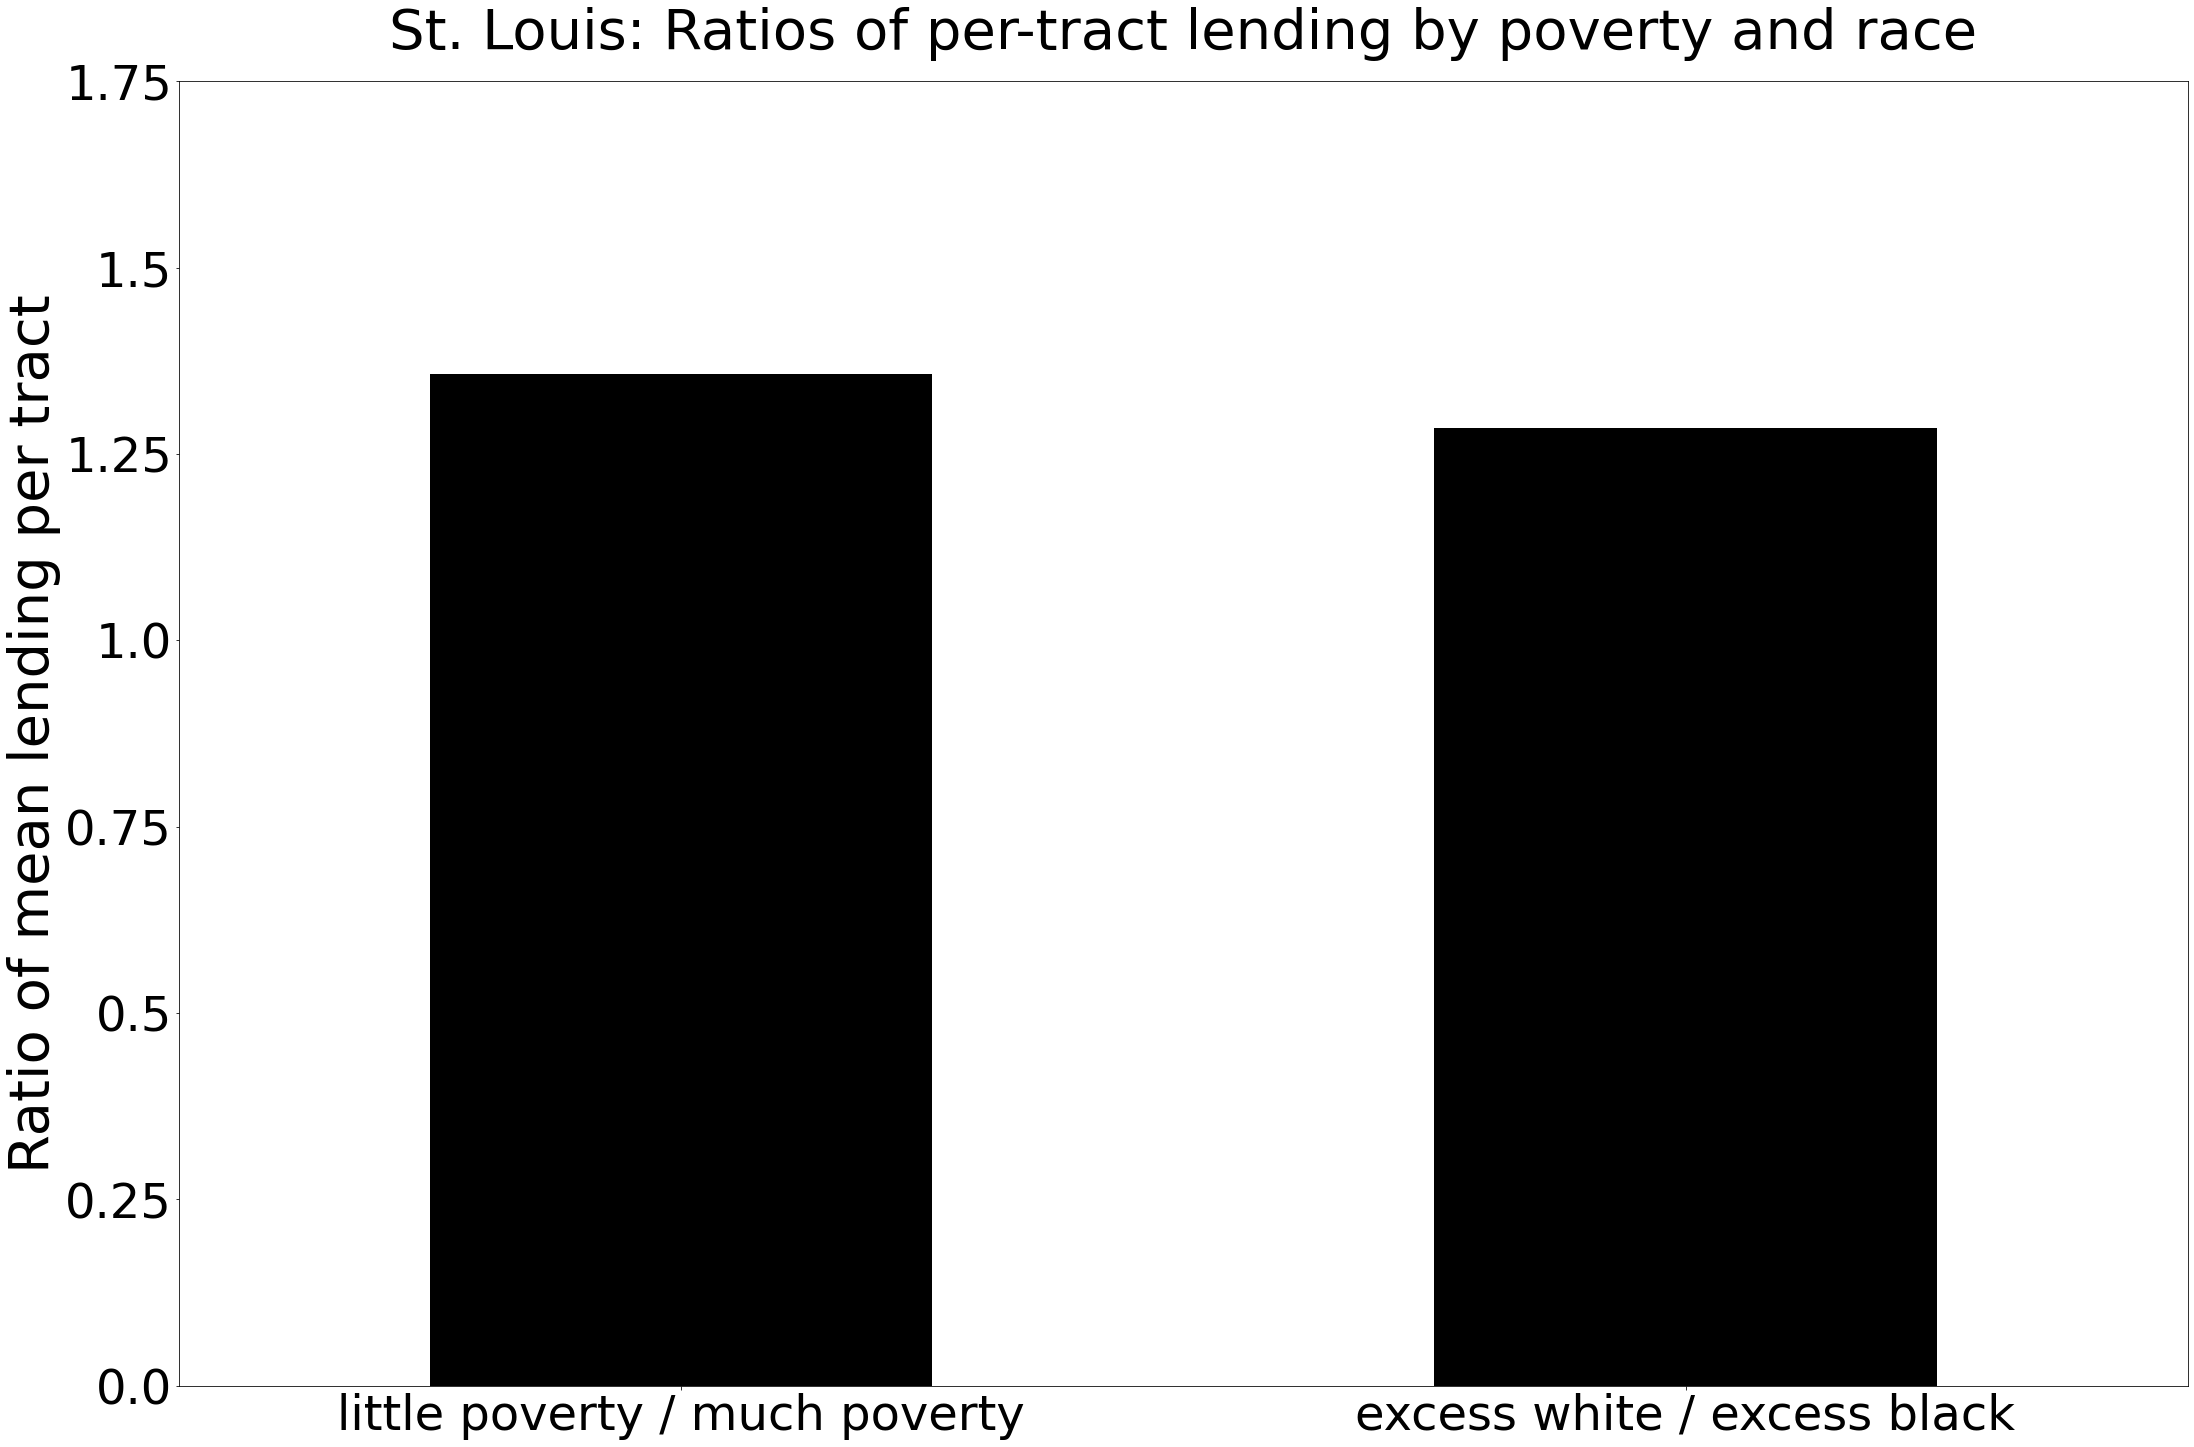

In [16]:
s = time.time()
bar_chart_df = pandas.DataFrame(data=None, columns=['mean_amtWorkingLoans_adj_per_sbjob'])
bar_chart_df.loc[
    'little poverty / much poverty', 'mean_amtWorkingLoans_adj_per_sbjob'
] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['poverty_class_2019'] == 'little') & (tracts_included_gdf['cra_level_2019'] != 'unknown')
].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['poverty_class_2019'] == 'much') & (tracts_included_gdf['cra_level_2019'] != 'unknown')
].mean()

bar_chart_df.loc[
    'excess white / excess black', 'mean_amtWorkingLoans_adj_per_sbjob'
] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['excess_race_2019'] == 'white') & (tracts_included_gdf['cra_level_2019'] != 'unknown')
].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['excess_race_2019'] == 'black') & (tracts_included_gdf['cra_level_2019'] != 'unknown')
].mean()
#bar_chart_df.loc['excess white / excess black', 'mean_amtWorkingLoans_adj_per_sbjob'] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2019'] == 'white'].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2019'] == 'black'].mean()

fig2, ax = plt.subplots(1,1, figsize=(36*scale, 24*scale))
bar_chart_df.plot.bar(ax=ax, color='black')

plt.xticks(np.arange(0,2), bar_chart_df.index.values, rotation='horizontal', fontsize=48*scale)

plt.ylabel('Ratio of mean lending per tract', fontsize=56*scale)
plt.yticks(np.arange(0, 2, 0.25), np.arange(0, 2, 0.25), fontsize=48*scale)

plt.title('{0:}: Ratios of per-tract lending by poverty and race'.format(city), fontsize=56*scale, y=1.02)
ax.get_legend().remove()

plt.savefig(figdir+'{0:}_lending_ratios.jpg'.format(city.lower().replace('.','').replace(' ','_')), format='jpg', dpi=300*scale)

summary['lending_ratio_race'] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2019'] == 'white'].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2019'] == 'black'].mean()

e = time.time()
g = g + (e-s)
print('Done in {0:.2f} seconds!'.format(e-s))

plt.show()


[0, 1, 2, 3, 4]
White 0: mean = $1,708, sem = $658
Black 0: mean = $1,113, sem = $171
White 1: mean = $1,788, sem = $390
Black 1: mean = $1,437, sem = $365
White 2: mean = $1,510, sem = $259
Black 2: mean = $1,541, sem = $299
White 3: mean = $1,620, sem = $334
Black 3: mean = $1,479, sem = $654
White 4: mean = $763, sem = $0
Black 4: mean = $658, sem = $0
Done in 7.08 seconds!


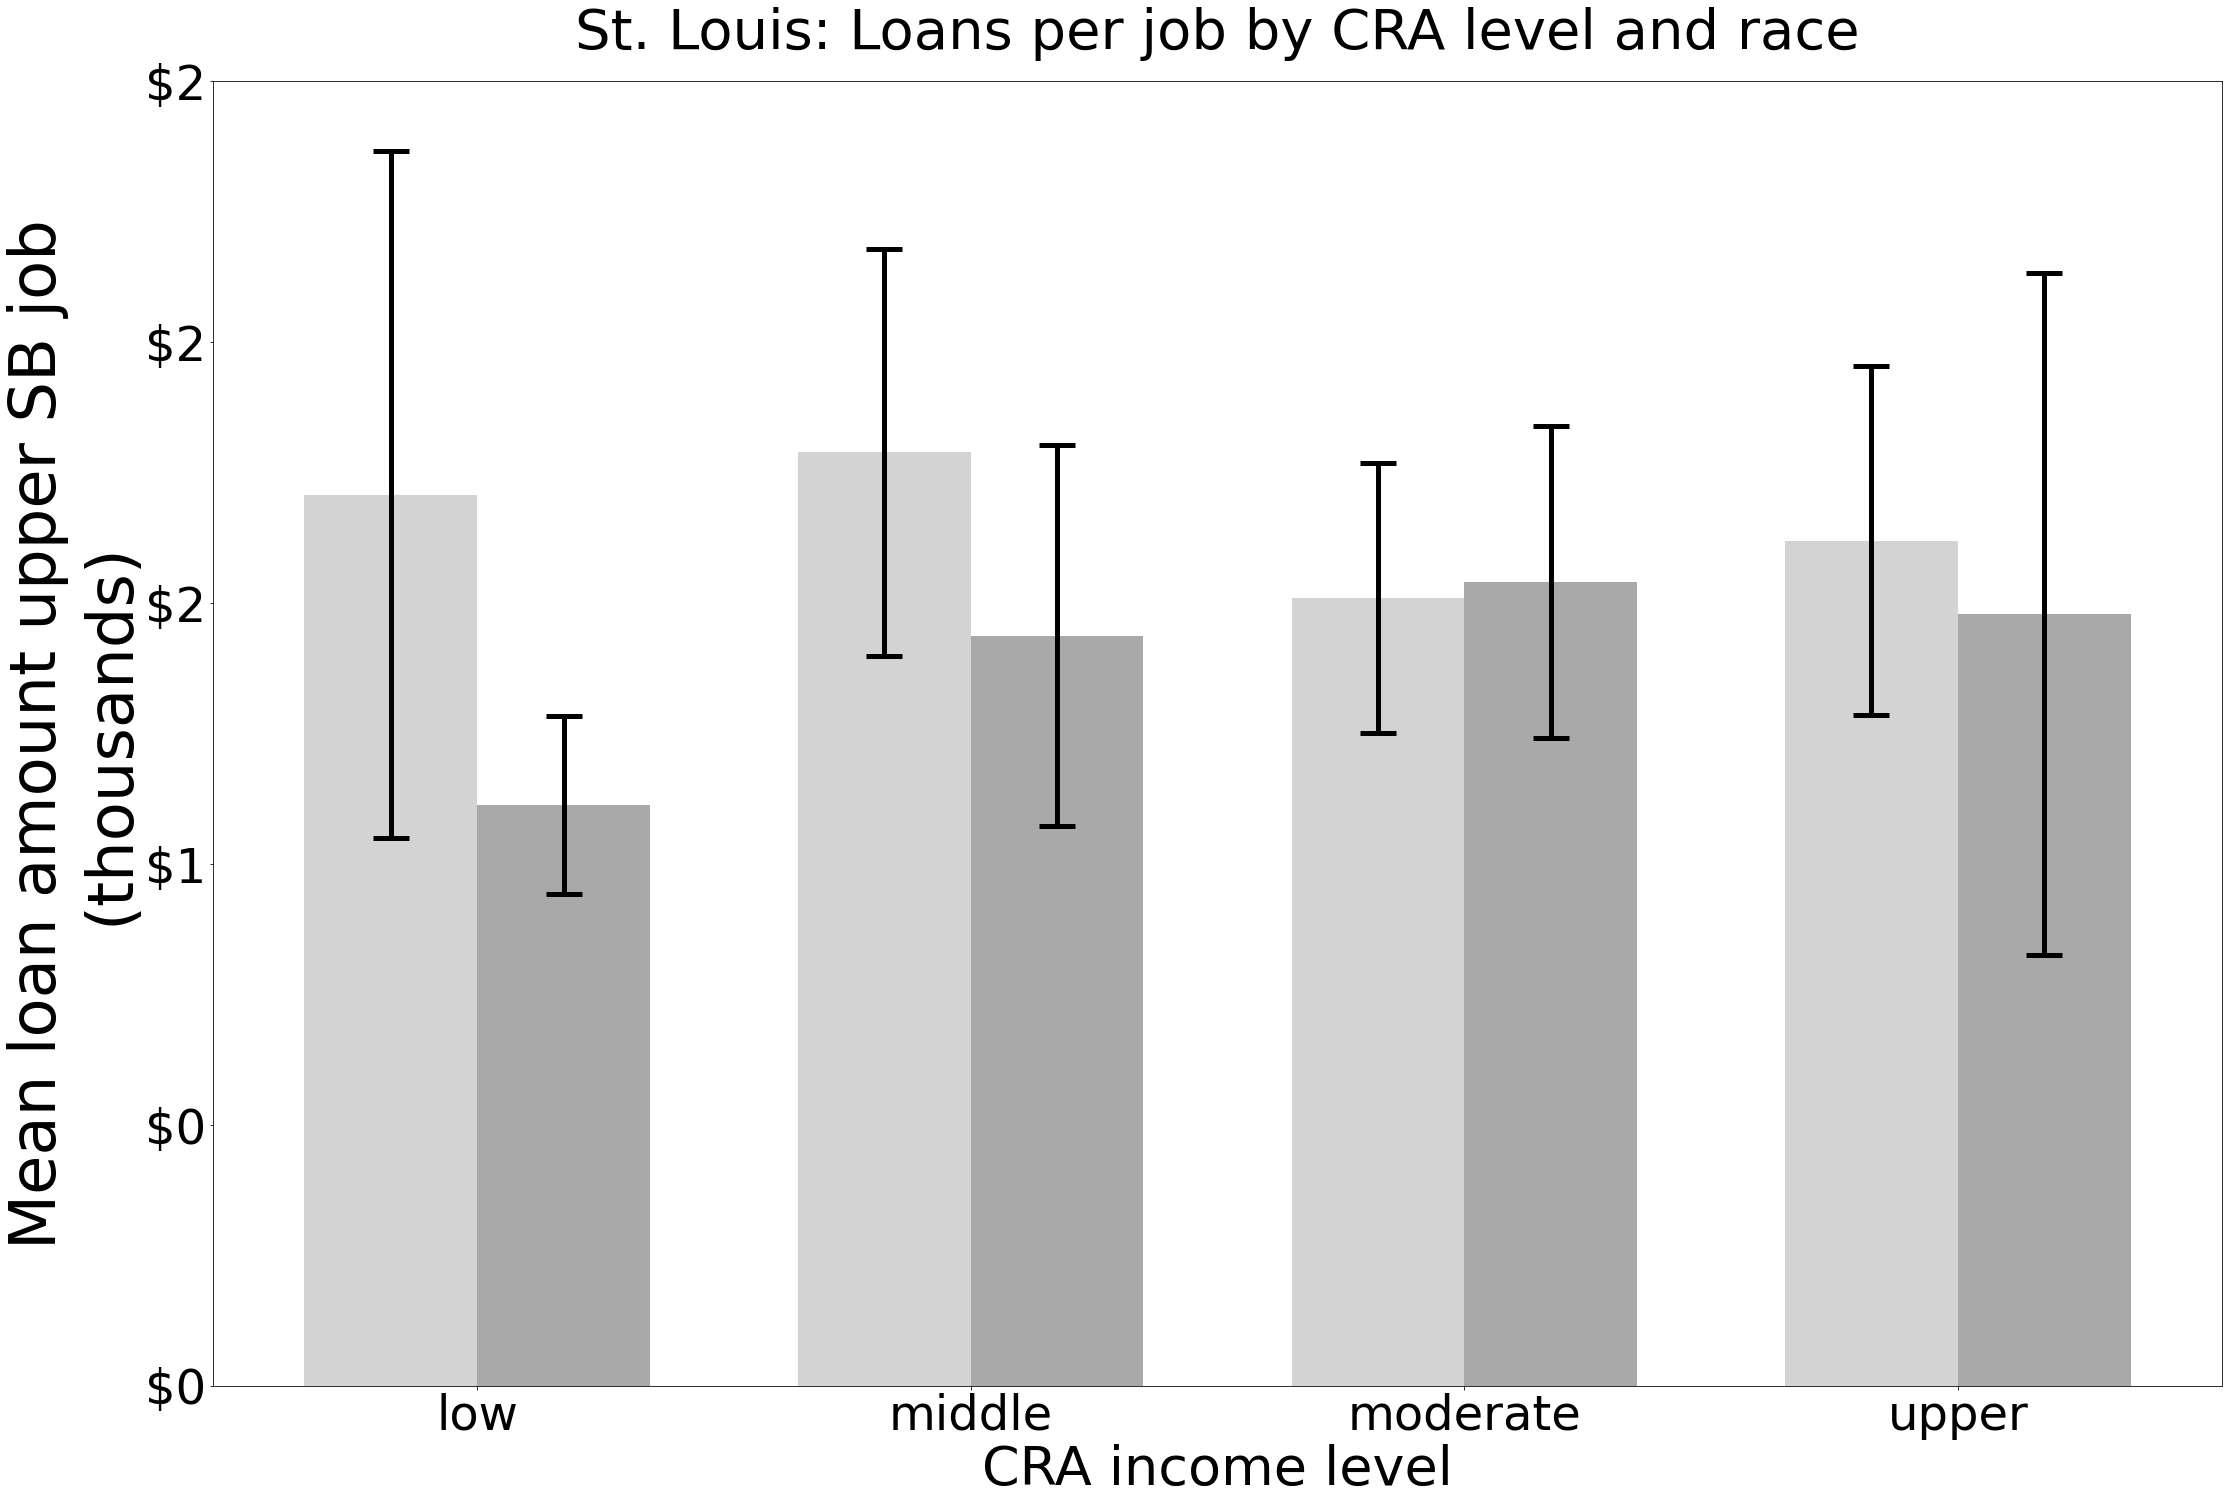

In [17]:
s = time.time()

fig3, ax = plt.subplots(1,1, figsize=(36*scale, 24*scale))


label_sorter = np.arange(5).tolist()
width = 0.35
print(label_sorter)

white_means = cra_level_race_df.xs('white')['mean_amtWorkingLoans_per_sbjob_adj'].tolist()
black_means = cra_level_race_df.xs('black')['mean_amtWorkingLoans_per_sbjob_adj'].tolist()
other_means = cra_level_race_df.xs('other')['mean_amtWorkingLoans_per_sbjob_adj'].tolist()

white_sems = cra_level_race_df.xs('white')['sem_amtWorkingLoans_per_sbjob_adj'].tolist()
black_sems = cra_level_race_df.xs('black')['sem_amtWorkingLoans_per_sbjob_adj'].tolist()
other_sems = cra_level_race_df.xs('other')['sem_amtWorkingLoans_per_sbjob_adj'].tolist()

for thisvar in [white_means, white_sems, black_means, black_sems]:
    for i in range(0, len(label_sorter)):
        if (np.isnan(thisvar[i])):
            thisvar[i] = 0
            
for i in label_sorter:
    print('White {0}: mean = ${1:,.0f}, sem = ${2:,.0f}'.format(label_sorter[i], white_means[i], white_sems[i]))
    print('Black {0}: mean = ${1:,.0f}, sem = ${2:,.0f}'.format(label_sorter[i], black_means[i], black_sems[i]))

plt.bar(label_sorter[:-1], white_means[:-1], width, yerr=white_sems[:-1], label='White', color='lightgray', error_kw=dict(lw=5*scale, capsize=18*scale, capthick=5*scale))
plt.bar([x+width for x in label_sorter[:-1]], black_means[:-1], width, yerr=black_sems[:-1], label='Black', color='darkgray', error_kw=dict(lw=5*scale, capsize=18*scale, capthick=5*scale))


plt.xticks([x+(width/2) for x in label_sorter[:-1]], ['low', 'middle', 'moderate', 'upper'], fontsize=48*scale)
plt.yticks(fontsize=48*scale)


ticks_loc = ax.get_yticks().tolist()
ax.set_yticks(ax.get_yticks().tolist())

tick_label_list = []
for tick in ax.get_yticks():
    tick_label_list.append(tick)
tick_label_list = ['${0:.0f}'.format(x/1000) for x in tick_label_list]

ax.set_yticklabels(tick_label_list)

plt.xlabel('CRA income level', fontsize=54*scale)
plt.ylabel('Mean loan amount upper SB job\n(thousands)', fontsize=64*scale)
plt.title('{0:}: Loans per job by CRA level and race'.format(city), fontsize=56*scale, y=1.02)

plt.savefig(figdir+'{0:}_cra_level_race.jpg'.format(city.lower().replace('.','').replace(' ','_')), format='jpg', dpi=300*scale)

e = time.time()
g = g + (e-s)
print('Done in {0:.2f} seconds!'.format(e-s))

#plt.show()

<ipython-input-18-4c0cccd3edc1>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(tick_label_list, fontsize=36*scale)


adding colorbar...
Done in 5.56 seconds!


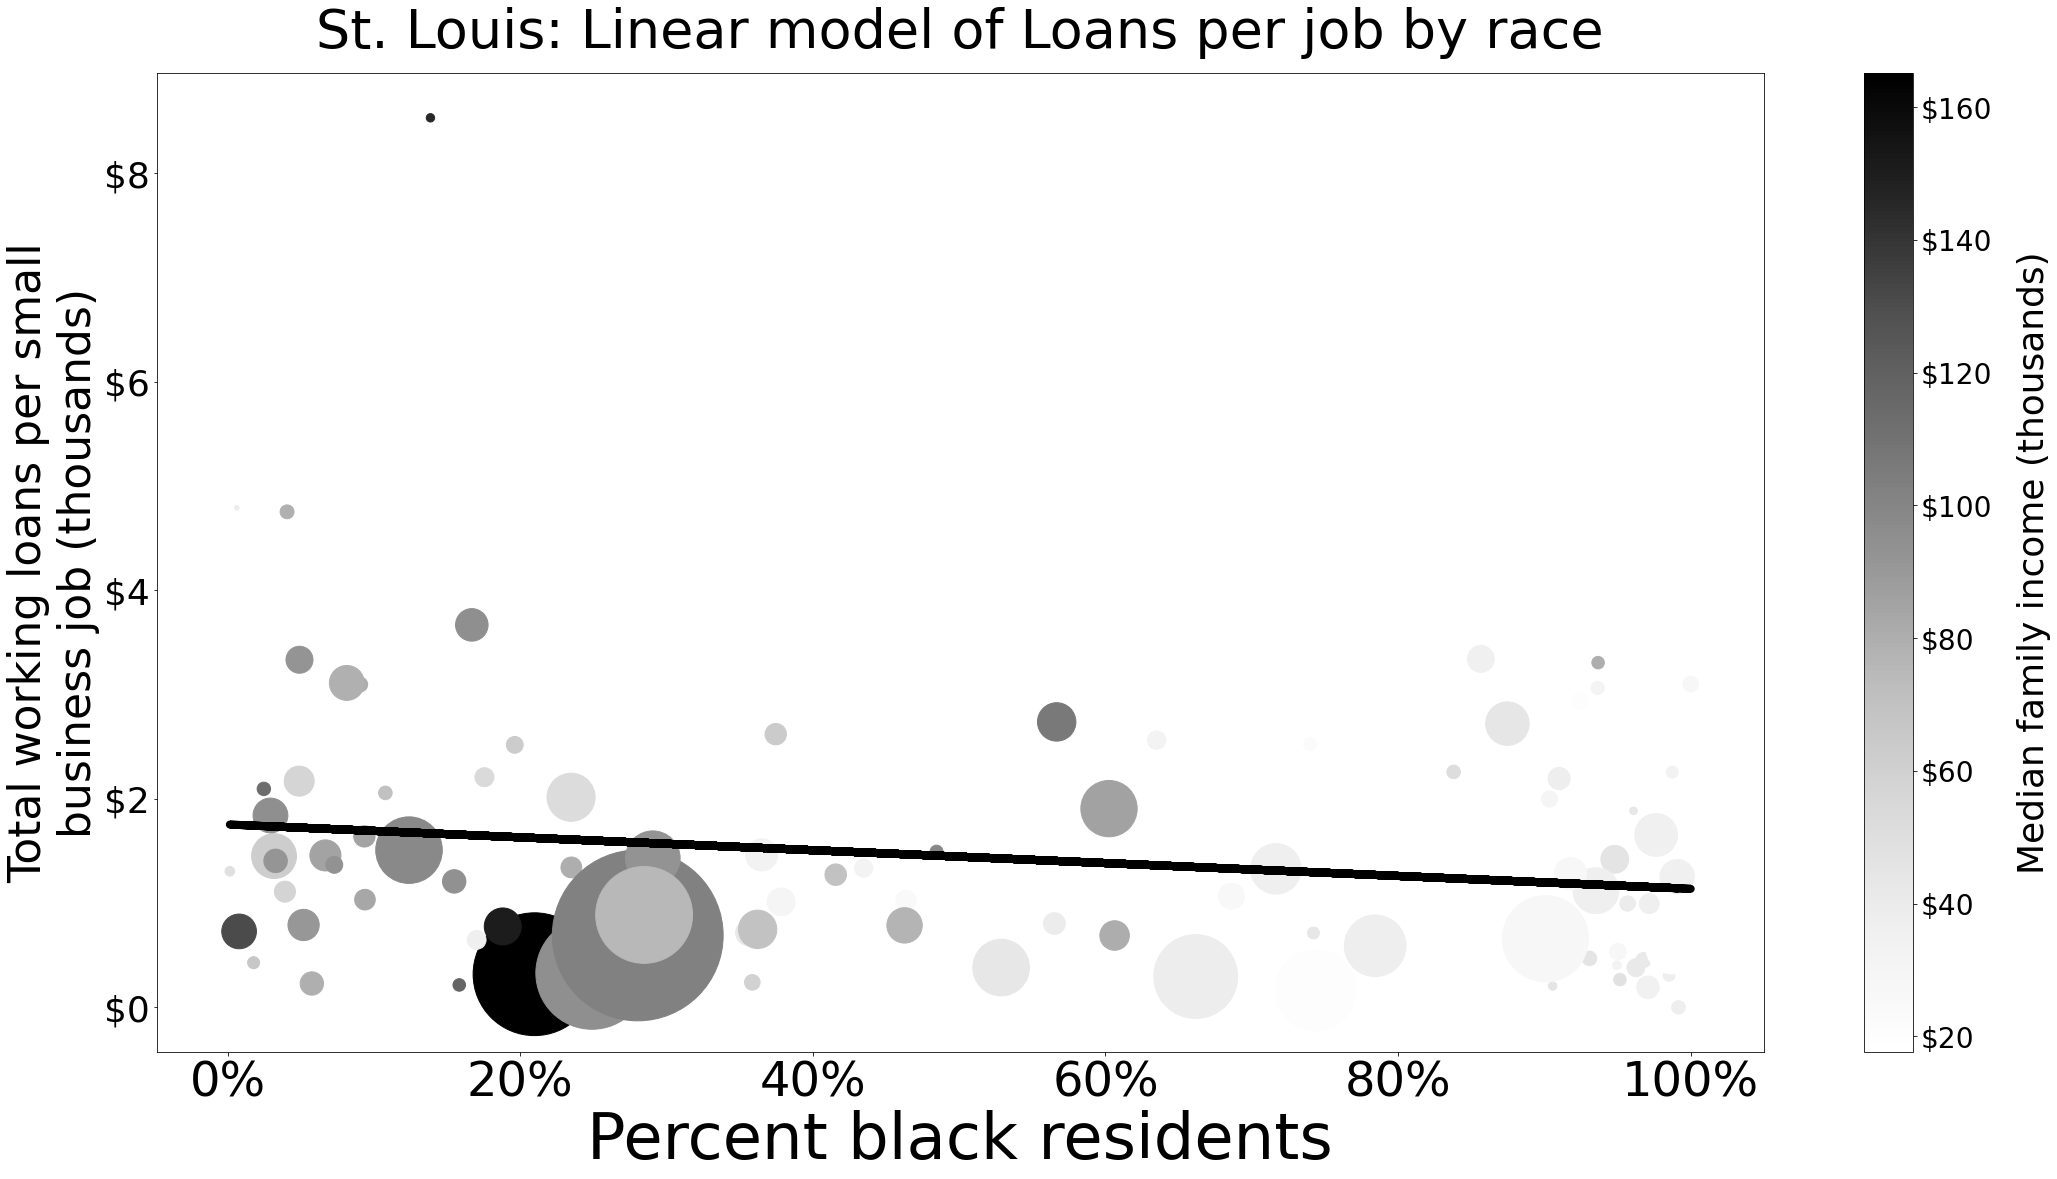

In [18]:
s = time.time()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    tracts_included_gdf['pct_black_2019'][tracts_included_gdf['pct_black_2019'].notnull()].apply(lambda x: x * 100).values, 
    tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['pct_black_2019'].notnull()].values
)

summary['race_fit_slope'] = slope
summary['race_fit_rsq'] = r_value**2

fig3, (ax3) = plt.subplots(1,1, figsize=(36*scale,18*scale))
siz = tracts_included_gdf['sb_jobs_2018'].apply(lambda x: (0.05*x)*(scale**2)).tolist()


#mfi_colormap = cm.viridis(np.linspace(0, 1, len(tracts_included_gdf)))

ax3.scatter(tracts_included_gdf['pct_black_2019'], 
            tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'], 
            s=siz, c=tracts_included_gdf['mfi_adj_2019'], cmap=thecolormap)

ax3.plot(tracts_included_gdf['pct_black_2019'], slope*tracts_included_gdf['pct_black_2019'].apply(lambda x: x * 100) + intercept, 
         color='black', linewidth=8*scale)

ax3.set_xlabel('Percent black residents', fontsize=64*scale)
ax3.set_ylabel('Total working loans per small\nbusiness job (thousands)', fontsize=44*scale)


xticks = np.arange(0, 1.2, 0.2)
xlabels = ['{0:.0%}'.format(x) for x in xticks]
plt.xticks(xticks, xlabels, fontsize=48*scale)

tick_label_list = []
for tick in ax3.get_yticks():
    tick_label_list.append(tick)

tick_label_list = ['${0:.0f}'.format(x/1000) for x in tick_label_list]
ax3.set_yticklabels(tick_label_list, fontsize=36*scale)

plt.title('{0:}: Linear model of Loans per job by race'.format(city), fontsize=54*scale, y=1.02)


print('adding colorbar...')

sm = plt.cm.ScalarMappable(cmap=thecolormap, norm=plt.Normalize(
    vmin=tracts_included_gdf['mfi_adj_2019'].min(), 
    vmax=tracts_included_gdf['mfi_adj_2019'].max()
))
## fake up the array of the scalar mappable. Urgh...
sm._A = []


#cax = fig3.add_axes()#[0.85, 0.4, .95, 0.5])

cbar = fig3.colorbar(sm)

cbarticklabels = []
for t in cbar.ax.get_yticks(): 
    cbarticklabels.append(t)
    #t = int(t.get_text()) / 1000#print(t.get_text())
cbarticklabels = ['${0:.0f}'.format(x/1000) for x in cbarticklabels]
cbar.set_ticks([x for x in cbar.ax.get_yticks()])
cbar.set_ticklabels(cbarticklabels)
cbar.ax.tick_params(labelsize=28*scale) 
cbar.set_label('Median family income (thousands)', rotation=90, size=36*scale, labelpad=25)#, y=1.05, rotation=90)

plt.savefig(figdir+'{0:}_linear_fit_race.jpg'.format(city.lower().replace('.','').replace(' ','_')), format='jpg', dpi=300*scale)
e = time.time()
g = g + (e-s)
print('Done in {0:.2f} seconds!'.format(e-s))
plt.show()


In [19]:
s = time.time()

summary['pop_all_tracts_2019'] = all_tracts_gdf['pop_total_2019'].sum()
summary['pop_included_in_study_2019'] = tracts_included_gdf['pop_total_2019'].sum()
summary['sb_jobs_included_in_study_2018'] = tracts_included_gdf['sb_jobs_2018'].sum()

summary['tracts_included'] = tracts_included_gdf.shape[0]
summary['nWorkingLoans'] = tracts_included_gdf['nWorkingLoans'].sum()
summary['amtWorkingLoans_adj'] = tracts_included_gdf['amtWorkingLoans_adj'].sum()

if (summary['race_fit_slope'] >= 0):
    summary['slopesign'] = ''
else:
    summary['slopesign'] = '-'
    
text = '{0:}'.format(city.upper())
text += '\n'
text += 'Total city population: {0:,.0f}\n'.format(summary['pop_all_tracts_2019'])
text += 'Population included in study: {0:,.0f}\n'.format(summary['pop_included_in_study_2019'])
text += 'Small business jobs included in study: {0:,.0f}\n'.format(summary['sb_jobs_included_in_study_2018'])
text += '\n'
text += 'Census tracts included in study: {0:,.0f}\n'.format(summary['tracts_included'])
text += 'City-wide percent black residents: {0:.1%}\n'.format(summary['city_pct_black'])
text += 'Number of working loans: {0:,.0f}\n'.format(summary['nWorkingLoans'])
text += 'Total amount of working loans ({0:.0f}USD): ${1:,.0f}\n'.format(latest_year,summary['amtWorkingLoans_adj'])
text += '\n'
text += 'Race lending ratio: {0:.2f}\n'.format(summary['lending_ratio_race'])
text += 'Slope of best-fit line for lending by race:\n\t{0:}${1:,.0f} per SB job per percent black (r^2 = {2:.3f})'.format(summary['slopesign'], np.abs(summary['race_fit_slope']), summary['race_fit_rsq'])

print('writing summary file...')
with io.open(figdir+'{0:}_summary.txt'.format(city.lower().replace('.','').replace(' ','_')), 'w') as f:
    f.write(text)

e = time.time()
g = g + (e-s)
print('\n')
print('Grand total time: {0:.1f} seconds!'.format(g))


writing summary file...


Grand total time: 168.9 seconds!
